   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.3 MB/s eta 0:00:00
Archive:  fonts.zip
   creating: fonts/
  inflating: fonts/AGENCYB.TTF       
  inflating: fonts/AGENCYR.TTF       
  inflating: fonts/ALGER.TTF         
  inflating: fonts/ANTQUAB.TTF       
  inflatin

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 186MB/s]


Epoch 01 | TrainAcc=0.5497  TestAcc=0.8640


Epoch 02 | TrainAcc=0.8375  TestAcc=0.8960


Epoch 03 | TrainAcc=0.8700  TestAcc=0.8740


Epoch 04 | TrainAcc=0.8748  TestAcc=0.8710


Epoch 05 | TrainAcc=0.8625  TestAcc=0.9030


Epoch 06 | TrainAcc=0.8875  TestAcc=0.9010


Epoch 07 | TrainAcc=0.8902  TestAcc=0.8930


Epoch 08 | TrainAcc=0.9010  TestAcc=0.9040


Epoch 09 | TrainAcc=0.9077  TestAcc=0.8980


Epoch 10 | TrainAcc=0.9025  TestAcc=0.9100
✅ Best test acc = 0.9100  (weights saved)


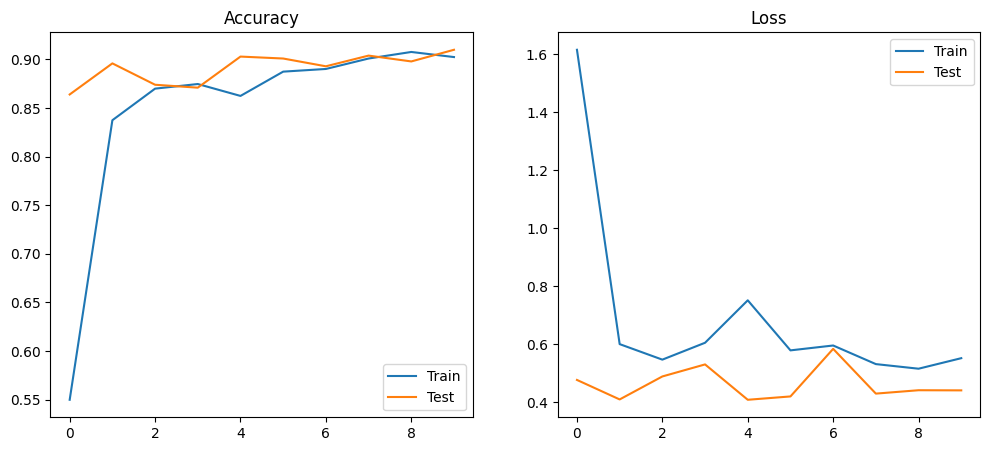

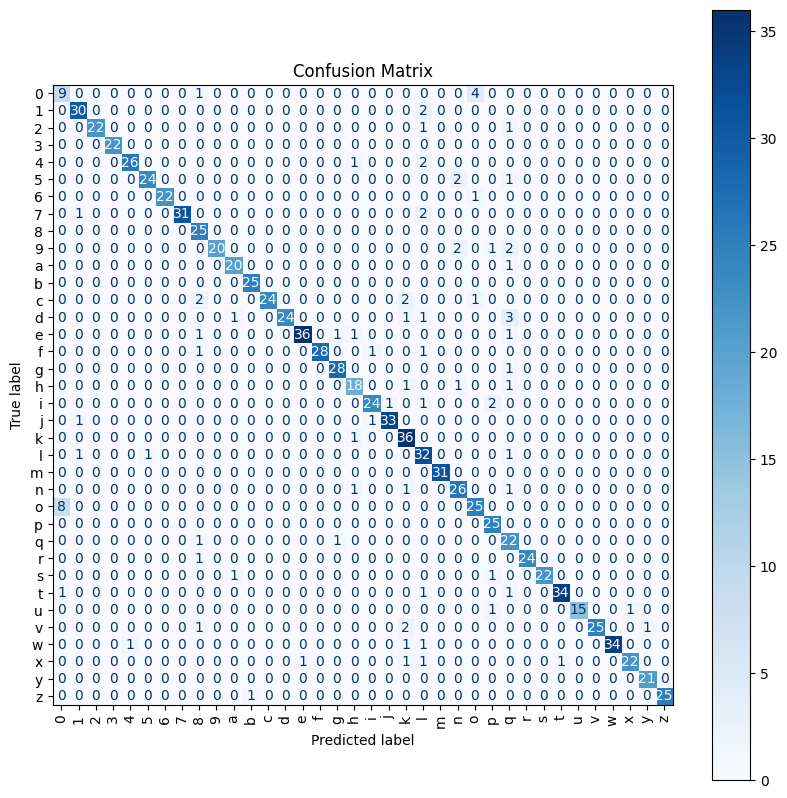

In [1]:
# ================= Colab 單格腳本：VGG16 單字元 CAPTCHA 訓練 =================
# 0. 安裝必要套件（torch 與 torchvision 已預裝於 GPU 筆記本可省略再安裝）
!pip -q install torch torchvision pillow matplotlib scikit-learn tqdm
!unzip -o fonts.zip
# 1. 產生資料集 ----------------------------------------------------------------
#    假設你已經把 data.py、perturber.py、fonts/ 目錄上傳到 /content/
from data import generate_dataset, get_font_paths
import string, torch, numpy as np, matplotlib.pyplot as plt
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path
from tqdm import tqdm

# (1) 資料集參數
dataset_root = "dataset"
if not Path(dataset_root, "clean").exists():           # 若尚未產生則自動產生
    cfg = {
        "length": 1,
        "charset": string.digits + string.ascii_lowercase,
        "font_paths": get_font_paths("fonts"),         # 需有 fonts/
        "font_size": 42,
        "image_size": (60, 60),
        "bg_color": "white",
        "char_color": "black",
        "char_spacing": 4,
        "seed": 42,
        "x_jitter": 5,
        "y_jitter": 5,
        "wave_amplitude": 2.0,
        "background_blur": True,
    }
    generate_dataset(dataset_root, n_samples=5000, dataset_config=cfg, noise_config=None)

# 2. 資料載入與前處理 ------------------------------------------------------------
BATCH_SIZE   = 32
EPOCHS       = 10
LR           = 1e-3
SEED         = 42
DATASET_DIR  = f"{dataset_root}/clean"
torch.manual_seed(SEED)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
dataset = ImageFolder(root=DATASET_DIR, transform=transform)
num_classes = len(dataset.classes)
assert num_classes == 36, f"class 數應為 36, 目前 {num_classes}"
idx = np.arange(len(dataset)); np.random.seed(SEED); np.random.shuffle(idx)
split  = int(0.8*len(dataset))
train_set = torch.utils.data.Subset(dataset, idx[:split])
test_set  = torch.utils.data.Subset(dataset, idx[split:])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False)
print(f"#train={len(train_set)}  #test={len(test_set)}")

# 3. 建立模型 -------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
model = models.vgg16(pretrained=True)
for p in model.features.parameters():
    p.requires_grad = False                         # 凍結卷積層
model.classifier[6] = nn.Linear(4096, num_classes)  # 36 類
model.to(device)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# 4. 訓練迴圈 -------------------------------------------------------------------
train_acc, test_acc, train_loss, test_loss = [], [], [], []
best_acc, best_wts = 0, None
for epoch in range(1, EPOCHS+1):
    # --- Train ---
    model.train(); t_corr=t_total=0; t_loss=0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward(); optimizer.step()
        t_loss += loss.item()*y.size(0)
        t_corr += (out.argmax(1)==y).sum().item()
        t_total += y.size(0)
    train_acc.append(t_corr/t_total); train_loss.append(t_loss/t_total)

    # --- Test ---
    model.eval(); v_corr=v_total=0; v_loss=0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            v_loss += criterion(out, y).item()*y.size(0)
            v_corr += (out.argmax(1)==y).sum().item()
            v_total += y.size(0)
    test_acc.append(v_corr/v_total); test_loss.append(v_loss/v_total)
    print(f"Epoch {epoch:02d} | TrainAcc={train_acc[-1]:.4f}  TestAcc={test_acc[-1]:.4f}")

    if test_acc[-1] > best_acc: best_acc, best_wts = test_acc[-1], model.state_dict()

# 5. 保存模型 --------------------------------------------------------------------
torch.save(best_wts, "vgg16_char_best.pt")
print(f"✅ Best test acc = {best_acc:.4f}  (weights saved)")

# 6. 繪圖 ------------------------------------------------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.plot(train_acc,label='Train'); plt.plot(test_acc,label='Test')
plt.title("Accuracy"); plt.legend()
plt.subplot(1,2,2); plt.plot(train_loss,label='Train'); plt.plot(test_loss,label='Test')
plt.title("Loss"); plt.legend(); plt.show()

# 7. 混淆矩陣 --------------------------------------------------------------------
model.load_state_dict(best_wts); model.eval()
all_p, all_y = [], []
with torch.no_grad():
    for x,y in test_loader:
        out = model(x.to(device)); all_p += out.argmax(1).cpu().tolist(); all_y += y.tolist()
cm  = confusion_matrix(all_y, all_p)
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay(cm, display_labels=dataset.classes).plot(ax=ax, cmap='Blues',
                                                                xticks_rotation='vertical',
                                                                values_format='d')
plt.title("Confusion Matrix"); plt.show()
# ================================================================================
